# Plagiarism Detection
### Dataset
The dataset used here is a small sample taken from the [International Competition on Plagiarism Detection PAN 2010](https://www.uni-weimar.de/en/media/chairs/computer-science-department/webis/data/corpus-pan-pc-10/). It consists of two kinds of files - suspicious documents and source documents. The dataset also contains information about whether a suspicious documents is plagiarized or not from the source documents. 

### Model overview
We have built a classifier below to classify the suspicious documents as plagiarized or not. This is done in broadly two steps:
1. First we derive four distinct similarity measures for each suspicious document. Two of the measures - Jaccard similarity coefficient and containment measure - are derived from the overlapping of the **trigrams** of the text, the next measure longest common sequence is derived from the tokens of the text whereas the last one is derived from the closeness of the vectors in Latent Semantic Analysis (LSA). 
2. Next we use these measures as the features for the suspicious documents to train a logistic regression classifier on them. 

### Rationale
Plagiarism comes in many forms. The first two of the similarity measures coming from the trigrams is targeted to catch the copying of the text from the source documents whereas the similarity measure related to LSA attempts to catch the restructuring, revising and paraphrasing of the original text.  

The model is designed after reviewing the literature and playing with various ideas. Many ideas, such as the first three similarity measures, are borrowed from the paper [Using Natural Language Processing for Automatic Detection of Plagiarism](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.458.9440&rep=rep1&type=pdf)  by Miranda Chong, et. al. For the text pre-processing, the detailed analysis from the paper  [The Influence of Text Pre-processing on Plagiarism Detection](https://pdfs.semanticscholar.org/a47c/1a35e2858da1eb82077b572e538a7b0b7b2d.pdf) is taken into account while building the model. The figure 2 in the paper clearly depicts the impact of the most commonly used text preprocessing methods. The following decisions are made for text preprocessing:
1. Stopwords and punctutations are removed.
2. Sentence segmentation is avoided since the plagiarism seem to span across consecutive sentences, hence the trigrams linking the sentences are useful as well.
3. Numbers are removed at the very beginning.
4. Lowercase is used throughout the text.
5. Lemmatization is used but only for deriving the last feature (or measure) using LSA.
6. POS-tagging might prove to be useful but the current model does not use it


### Tools used: re (regular expressions), numpy, pandas, nltk, sklearn
'
### Ideas/Future work
* Text preprocessing: POS-tagging, synonymy recognition, etc.
* Using bigrams, 4-grams and/or 5-grams along with (or instead of) trigrams
* Deriving more features for the classifier using more similarity measures or other approaches
* Tuning the parameters for the logistic regression classifier
* Modifying/optimizing the code for large-scale data

### Challenges
* Multi-source plagiarism:  When each suspicious documents is compared with all source documents to calculate the similarity meaures, the highest scores are considered. Thus, multi-source plagiarism  is not taken into account. This can be fixed by instead considering the average of the top 3 scores while calculating the similarity measures.
* Language translation: Our model does not cover the plagiarism caused by translating the original text in another language
* Paraphrasing is only partially addressed.
* Model so far has a serious flaw that it might also flag a document that has properly quoted from the original source along with giving correct reference. This can be fixed by looking for the quotations at the very beginning. Check that the source for each quotation is properly attributed and then removing the quote along with the reference text.  
* Model is built as a classifier that needs labeled data to train it.

### Data Processing
We start by importing the relevant modules.

In [1]:
import numpy as np 
import pandas as pd 
import re

import os
path = "input/" # Update path

import nltk
from nltk import trigrams, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Below are the functions to clean the text files and combine the files to give dataframes - one each for the source and the suspicious files:

In [2]:
def clean_file(myfile):
    mf = myfile.read()
    mf = mf.lower()
    mf = re.sub(r'[\n]\s*',r' ', mf)
    mf = re.sub(r'[\']|[:]|[+]|\d+|[--]', '', mf)
    mf = re.sub(r'\(\)',r'', mf)
    mf = re.sub(r'\.\s+\.', r'.', mf)
    mf = mf.strip()
    return mf

def get_dataframe(files):
    data = []
    for f in files:
        with open(path + f, mode='r', encoding='utf-8-sig') as myfile:
            myfile = clean_file(myfile)
            data.append(myfile)
    df = pd.DataFrame(data, columns=['Text'])
    return df

Next we use the above functions to get a pandas dataframe for the suspicious file. The reason we put the files as a dataframe is because it will be easier to apply the same operations later on to each file.

In [3]:
suspicious_files = sorted([f for f in os.listdir(path) if f.startswith('suspicious-document')])
suspicious = get_dataframe(suspicious_files)
suspicious['File_index'] = [f[19:24] for f in suspicious_files]
plagiarized = pd.read_csv(path + "Plagiarized.csv")
suspicious['Plagiarized'] = plagiarized.Plagiarized
suspicious.head()

,Text,File_index,Plagiarized
0,bible studies in the life of paul historical a...,00001,1
1,my impatience to inhabit the hermitage not per...,00002,1
2,morning on the beachthe three letters i...,00003,1
3,this morning it rained so hard (though it was ...,00004,0
4,deadham hard a romance by lucas malet (mary st...,00005,1


Similarly, below is the dataframe for the source files:

In [4]:
source_files = sorted([f for f in os.listdir(path) if f.startswith('source-document')])
source = get_dataframe(source_files)
source['File_index'] = [f[15:20] for f in source_files]
source.head()

,Text,File_index
0,"our next day was a pleasant, lazy day, during ...",00018
1,she stepped back to scyllas side. there was a ...,00040
2,"punch, or the london charivari. volume . may ,...",00047
3,the leicestershires beyond baghdad by edward j...,00055
4,"""we soon began to find stones and dirt in the ...",00088


Now, we process the text to remove punctutations and stopwords. The we tokenize the text and finally get trigrams from the corpus of the files so that we can use them to detect plagiarism. 

In [5]:
def process_text(df):
    df['Tokens'] = df['Text'].apply(word_tokenize) 
    punc = (".", ",", "?", "-", "!", "'", '"', "\\", "/", ";", "{", "}", "(", ")", "[", "]", "''", "``")
    stop = set(stopwords.words('english'))
    stop_punc = stop.union(punc)
    df.Tokens = df.Tokens.apply(lambda x: [w for w in x if w not in stop_punc])
    df['Trigrams'] = df['Tokens'].apply(lambda x: set(trigrams(x)))
    return df

Getting trigrams for the suspicious files:

In [6]:
suspicious = process_text(suspicious)
suspicious.head()

,Text,File_index,Plagiarized,Tokens,Trigrams
0,bible studies in the life of paul historical a...,00001,1,"[bible, studies, life, paul, historical, const...","{(east, west, met), (ambition, must, restraine..."
1,my impatience to inhabit the hermitage not per...,00002,1,"[impatience, inhabit, hermitage, permitting, w...","{(harvey, since, definite), (though, scott, sa..."
2,morning on the beachthe three letters i...,00003,1,"[morning, beachthe, three, letters, iii, old, ...","{(said, gracious, father), (thought, flushed, ..."
3,this morning it rained so hard (though it was ...,00004,0,"[morning, rained, hard, though, fair, yesterda...","{(next, day, thence), (cunning, knave, point),..."
4,deadham hard a romance by lucas malet (mary st...,00005,1,"[deadham, hard, romance, lucas, malet, mary, s...","{(behind, cloves, think), (walk, topping, seaw..."


Getting trigrams for the source files:

In [7]:
source = process_text(source)
source.head()

,Text,File_index,Tokens,Trigrams
0,"our next day was a pleasant, lazy day, during ...",00018,"[next, day, pleasant, lazy, day, inspected, ka...","{(right, thing, hyena), (amazone, seemed, affo..."
1,she stepped back to scyllas side. there was a ...,00040,"[stepped, back, scyllas, side, deathly, doubt,...","{(said, slide, arms), (big, black, form), (hea..."
2,"punch, or the london charivari. volume . may ,...",00047,"[punch, london, charivari, volume, may, *, *, ...","{(smiles, day, advanced), (performances, comme..."
3,the leicestershires beyond baghdad by edward j...,00055,"[leicestershires, beyond, baghdad, edward, j.,...","{(beginning, tide, victory), (evenings, seemed..."
4,"""we soon began to find stones and dirt in the ...",00088,"[soon, began, find, stones, dirt, ice, gone, t...","{(situation, minute, emergency), (true, pole, ..."


### Similarity measures on trigrams

Next we compare the suspicious files with the source files using two similarity measures:
1. Jaccard similarity coefficient
2. Containment measure

The formulae and explanation for these measures can be found in this [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.458.9440&rep=rep1&type=pdf).

We write the code for the first two measures that are both used on trigrams.

In [8]:
def Jaccard_similarity_coefficient(A, B):
    J = len(A.intersection(B))/len(A.union(B))
    return J

def containment_measure(A, B):
    J = len(A.intersection(B))/len(B)
    return J

We write the functions to apply the above two measures to each suspicious file in the dataframe.  For each suspicious file, we compare it with all the source files and keep the highest score for the respective measure. 

In [9]:
def check_plagiarism_Jaccard(doc_trigrams):
    Jaccard_similarity_scores = source.Trigrams.apply(lambda s: Jaccard_similarity_coefficient(s, doc_trigrams))
    most_similar = Jaccard_similarity_scores.idxmax()
    return Jaccard_similarity_scores[most_similar]#, source.loc[most_similar, 'File_index']

def check_plagiarism_containment(doc_trigrams):
    containment_measure_scores = source.Trigrams.apply(lambda s: containment_measure(s, doc_trigrams))
    most_similar = containment_measure_scores.idxmax()
    return containment_measure_scores[most_similar]#, source.loc[most_similar, 'File_index']

We get the two measures for comparing the similarity between trigrams of suspicious and source files.  

In [10]:
suspicious['Jaccard_similarity_score'] = suspicious.Trigrams.apply(check_plagiarism_Jaccard)
suspicious['Containment_measure_score'] = suspicious.Trigrams.apply(check_plagiarism_containment)

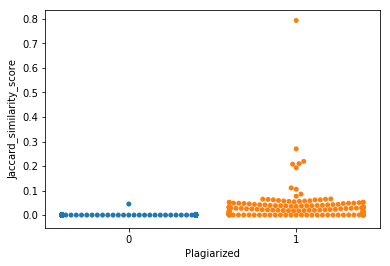

In [11]:
sns.swarmplot(x="Plagiarized", y="Jaccard_similarity_score", data=suspicious);

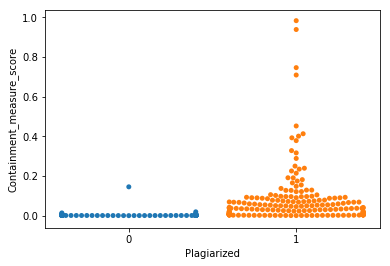

In [12]:
sns.swarmplot(x="Plagiarized", y="Containment_measure_score", data=suspicious);

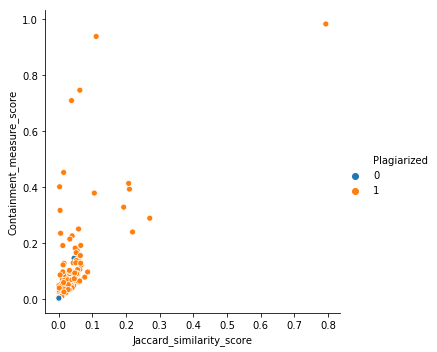

In [13]:
sns.relplot(x="Jaccard_similarity_score", y="Containment_measure_score", hue="Plagiarized", data=suspicious);

In [33]:
# sns.relplot(x="Jaccard_similarity_score", y="Containment_measure_score", hue="Plagiarized", data=suspicious)#, logscale=True);

### Longest common sequence

Next we define the function to find the longest common sequence among two list of tokens.

In [ ]:
def LCS(A, B):
    m, n = len(A), len(B)
    counter = [[0]*(n+1) for x in range(m+1)]
    A, B = list(A), list(B)
    longest = 0
    for i in range(m):
        for j in range(n):
            if A[i] == B[j]:
                count = counter[i][j] + 1
                counter[i+1][j+1] = count
                if count > longest:
                    longest = count
    return longest

def check_plagiarism_LCS(doc):
    LCS_scores = source.Tokens.apply(lambda s: LCS(s, doc))
    most_similar = LCS_scores.idxmax()
    return LCS_scores[most_similar]#, source.loc[most_similar, 'File_index']

Finding the length of the longest common sequence is the most computationally expensive step in the model:

In [ ]:
suspicious['Longest_common_sequence'] = suspicious.Trigrams.apply(check_plagiarism_LCS)

 ### Latent Semantic Analysis

First we lemmatize the tokens using `WordNetLemmatizer`.

In [14]:
lemmatizer = WordNetLemmatizer()
source.Tokens = source.Tokens.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
suspicious.Tokens = suspicious.Tokens.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

Next we use scikit-learn's ``TfidfVectorizer`` to get a document term matrix where the columns corresponds to the files (source and suspicious both). Since we want to make use of our pre-processed tokens instead of repeating the tokenizing process, we pass a dummy function to the vectorizer.

In [15]:
dummy_function = lambda x: x

vectorizer = TfidfVectorizer(
    analyzer='word',
    token_pattern=None,
    tokenizer=dummy_function,
    preprocessor=dummy_function,
    ngram_range=(1, 4),
    max_features=1000,
    ) 

DTM = vectorizer.fit_transform(suspicious.Tokens.append(source.Tokens))

Now we use scikit-learn's ``TruncatedSVD`` to apply Singular Value Decomposition on the document term matrix *DTM* obtained above to get a lower dimensional matrix *DTM_LSA* with dim=50 and then normalize it.

In [16]:
LSA = TruncatedSVD(50, algorithm = 'arpack')
DTM_LSA = LSA.fit_transform(DTM)
DTM_LSA = Normalizer(copy=False).fit_transform(DTM_LSA)

Since we have normalized the matrix ``DTM_LSA``,  the dot product of the vectors corresponding to two files will give the cosine angle between them, which is precisely the measure of similarity in this case. Hence, we get the similarity matrix by multiplying the matrix *DTM_LSA* with its transpose.

In [17]:
similarity_matrix = np.asarray(np.asmatrix(DTM_LSA) * np.asmatrix(DTM_LSA).T)

Next we find the highest similarity score for each suspicious document while considering the values corresponding to the source documents only. We achieve this by first setting all the diagonal values as well as the LXL square matrix to zero and taking the max value for each row.

In [18]:
np.fill_diagonal(similarity_matrix, 0)
L = len(suspicious_files)
similarity_matrix[:L, :L] = np.zeros((L, L))
suspicious['LSA_similarity'] = np.max(similarity_matrix, 1)[:L]

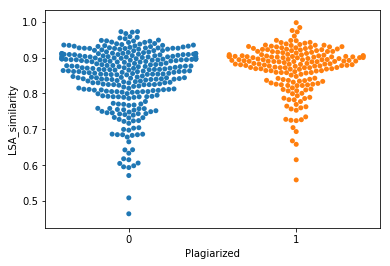

In [19]:
sns.swarmplot(x="Plagiarized", y="LSA_similarity", data=suspicious);

Correlation coefficients for the similarity measures and the target variable:

In [20]:
suspicious[['LSA_similarity', 'Jaccard_similarity_score', 'Containment_measure_score', 'Plagiarized']].corr()

,LSA_similarity,Jaccard_similarity_score,Containment_measure_score,Plagiarized
LSA_similarity,1.000000,0.139629,0.058424,0.150114
Jaccard_similarity_score,0.139629,1.000000,0.707689,0.332351
Containment_measure_score,0.058424,0.707689,1.000000,0.395896
Plagiarized,0.150114,0.332351,0.395896,1.000000


### Logistic regression classifier
The last step is to use all the similarity measures obtained above as the features for the suspicious documents and train a logistic regression model.  For that we split the suspicious documents into train and test sets and keep only the columns corresponding to the similarity measures.

In [21]:
y = suspicious.Plagiarized
X = suspicious[['LSA_similarity', 'Jaccard_similarity_score', 'Containment_measure_score']]#, 'Longest_common_sequence']]

clf = LogisticRegression()
cross_val_score(clf, X, y, cv=10)

0.76
0.665


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.69      1.00      0.82        67
          1       1.00      0.09      0.17        33

avg / total       0.79      0.70      0.60       100



In [30]:
y.value_counts()

0    311
1    189
Name: Plagiarized, dtype: int64


### References:
1. [Using Natural Language Processing for Automatic Detection of Plagiarism](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.458.9440&rep=rep1&type=pdf)
2. [The Role of Natural Language Processing Techniques in Plagiarism Detection](https://prezi.com/yhepkzz-qn76/the-role-of-natural-language-processing-techniques-in-plagiarism-detection/)
3. [The Influence of Text Pre-processing on Plagiarism Detection](https://pdfs.semanticscholar.org/a47c/1a35e2858da1eb82077b572e538a7b0b7b2d.pdf)
4. [Dataset](https://www.uni-weimar.de/en/media/chairs/computer-science-department/webis/data/corpus-pan-pc-10/)